# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Run this cell for first time only and restart the kernel
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

In [3]:
#Run this cell is you face problem while downloading dataset
#from ipywidgets import FloatProgress

In [4]:
#Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [5]:
#Import necessary libraries
from torchvision import datasets
from torch.utils.data import random_split, DataLoader

# Define transforms
transform = transforms.Compose(
[
    #Transform the pixel values(0-255) to a float tensor with range (0.0-1.0)
    transforms.ToTensor(),
    
    #Normalize the tensor
    transforms.Normalize((0.5), (0.5))
])

# Create training and validation set and define training dataloader
train_validation_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)

#Seperate 80% training data 20% validation data
total_length = len(train_validation_data)
train_length = int(total_length*0.8)
validation_length = total_length - train_length
train_data, validation_data = random_split(train_validation_data, [train_length, validation_length])

#Training dataset loader
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)

#Validation dataset loader
validation_loader = DataLoader(dataset=validation_data, batch_size=64, shuffle=False)

# Create test set and define test dataloader
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = DataLoader(test_data, batch_size=64)

/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**Transformation 1: ToTensor()**
This transformation is necessary because the pixel values range from 0 to 255. Such higher value are not supported by Tensor. So we convert the data in the range (0, 1). 

**Transformation 2: Normalize()**
Activation functions better work with data with mean value 0.5 and standard deviation of 0.5. MNIST data has only one channel, so we normalize this channel only.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [6]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

7


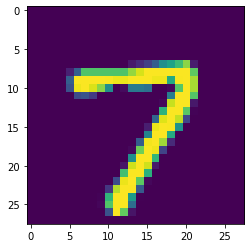

6


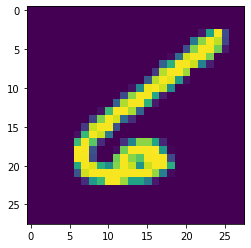

0


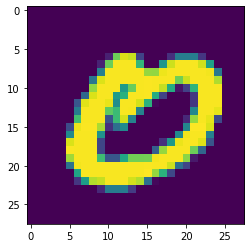

0


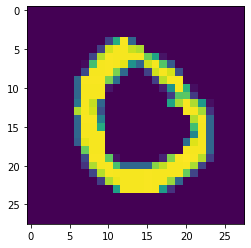

4


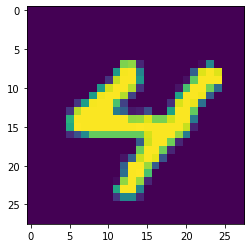

Shape of each image is: [1, 28, 28]


In [7]:
# Explore data
#Show some Training data
show5(train_loader)

#Shape of each image
dataiter = iter(train_loader)
batch = next(dataiter)
image = batch[0][0]
shape = list(image.shape)
height = shape[-2]
width = shape[-1]
print(f"Shape of each image is: {list(image.shape)}")

In [8]:
#Check number of Classes
n_classes = len(set(train_validation_data.targets.tolist()))

print(f"Total number of classes is {n_classes}")

Total number of classes is 10


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [9]:
#Defining Neural Networkc
class Net(nn.Module):
    def __init__(self, height, width, n_class):
        super(Net, self).__init__()
        
        #Height and width of the input image
        self.height = height
        self.width = width
        
        #input size to 450 hidden units
        self.fc1 = nn.Linear(height*width, 450)
        #Rectified Linear Activation
        self.relu1 = nn.ReLU()
        #40% dropout to overcome overfitting
        self.dropout1 = nn.Dropout(0.4)
        #450 hidden unit to 350 hidden unit
        self.fc2 = nn.Linear(450, 350)
        #Rectified Linear Activation
        self.relu2 = nn.ReLU()
        #30% dropout to overcome overfitting
        self.dropout2 = nn.Dropout(0.3)
        #380 hidden unit to n_class output unit
        self.fc3 = nn.Linear(350, n_class)
        
    def forward(self, x):
        #Flatten the input image
        x = x.view(-1, self.height*self.width)
        #Forward pass the input through the network
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [10]:
#Instantiate the model
model = Net(height, width, n_classes)

#Upload the model to GPU memory if available
model.to(device)

#Specify loss function
criterion = nn.CrossEntropyLoss()

#Specify optimizer
#Learnrate = 0.001
#L2 regularization by specifying weight decay to prevent overfitting
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [11]:
#Creating the training and validation loop

#Number of epochs
epochs = 40

#List for loss history
train_loss_history = []
val_loss_history = []

#Training and validation loop
for epoch in range(epochs):
    
    ##Training##
    
    #Set the model in traing mode
    model.train()
    
    #Initialize training loss for each epoch
    train_loss = 0.0
    
    #Count correct predictions while training
    train_correct = 0
    
    #Loop for each batch of data
    for i, data in enumerate(train_loader):
        #input images and labels
        inputs, labels = data
        
        #Upload data to GPU memory if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #Set gradient value value to zero
        optimizer.zero_grad()
        
        #Output of forward pass
        outputs = model(inputs)
        
        #Calculate cross entropy loss
        loss = criterion(outputs, labels)
        
        #Backpropagate the loss
        loss.backward()
        
        #Optimize the model by updating weights
        optimizer.step()
        
        #Extract model predictions
        _, predicts = torch.max(outputs.data, 1)
        
        #Calculate total number of correct predictions by comparing with labels
        num_corrects = (predicts == labels).sum().item()
        
        #Update the total number of correct predictions
        train_correct += num_corrects
        
        #Record the training loss
        train_loss += loss.item()
        
    ##Validation##
    with torch.no_grad():
    
        #Set the model in validation mode
        model.eval()

        #Initialize validation loss
        val_loss = 0.0

        #Count correct predictions
        val_correct = 0

        #Loop for each batch of data
        for i, data in enumerate(validation_loader):
            #input images and labels
            inputs, labels = data

            #Upload data to GPU memory if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            #Output of forward pass
            outputs = model(inputs)

            #Calculate cross entropy loss
            loss = criterion(outputs, labels)

            #Extract model predictions
            _, predicts = torch.max(outputs.data, 1)

            #Calculate total number of correct predictions by comparing with labels
            num_corrects = (predicts == labels).sum().item()

            #Update the total number of correct predictions
            val_correct += num_corrects

            #Record the training loss
            val_loss += loss.item()
        
    #Print accuracy and loss for each epoch
    
    #Calculating average loss and accuracy
    num_train_batches = len(train_loader)
    num_val_batches = len(validation_loader)
    train_length = len(train_loader.dataset)
    validation_length = len(validation_loader.dataset)
    
    avg_train_loss = train_loss/num_train_batches
    avg_val_loss = val_loss/num_val_batches
    avg_train_accuracy = train_correct/train_length
    avg_val_accuracy = val_correct/validation_length
    
    #Record training and validation loss history
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    
    #Messages
    messages = {
        "1" : f"Epoch: {epoch + 1}",
        "2" : "-"*10,
        "3" : "\tAccuracy:",
        "4" : f"\t\tTrain: {100*avg_train_accuracy:.4f}%",
        "5" : f"\t\tValidation: {100*avg_val_accuracy:.4f}%",
        "6" : "\tLoss:",
        "7" : f"\t\tTrain: {avg_train_loss:.4f}",
        "8" : f"\t\tValidation: {avg_val_loss:.4f}\n"    
    }
    
    #Print message
    for i in range(len(messages)):
        print(messages[f"{i+1}"])

Epoch: 1
----------
	Accuracy:
		Train: 86.0312%
		Validation: 92.5500%
	Loss:
		Train: 0.4447
		Validation: 0.2431

Epoch: 2
----------
	Accuracy:
		Train: 92.0146%
		Validation: 94.9250%
	Loss:
		Train: 0.2591
		Validation: 0.1702

Epoch: 3
----------
	Accuracy:
		Train: 93.4896%
		Validation: 95.6500%
	Loss:
		Train: 0.2168
		Validation: 0.1433

Epoch: 4
----------
	Accuracy:
		Train: 94.1750%
		Validation: 95.2250%
	Loss:
		Train: 0.1914
		Validation: 0.1586

Epoch: 5
----------
	Accuracy:
		Train: 94.4562%
		Validation: 96.0167%
	Loss:
		Train: 0.1766
		Validation: 0.1290

Epoch: 6
----------
	Accuracy:
		Train: 94.9583%
		Validation: 96.7917%
	Loss:
		Train: 0.1635
		Validation: 0.1074

Epoch: 7
----------
	Accuracy:
		Train: 95.0771%
		Validation: 96.8500%
	Loss:
		Train: 0.1616
		Validation: 0.1101

Epoch: 8
----------
	Accuracy:
		Train: 95.2792%
		Validation: 96.4500%
	Loss:
		Train: 0.1549
		Validation: 0.1159

Epoch: 9
----------
	Accuracy:
		Train: 95.3479%
		Validation: 9

Plot the training loss (and validation loss/accuracy, if recorded).

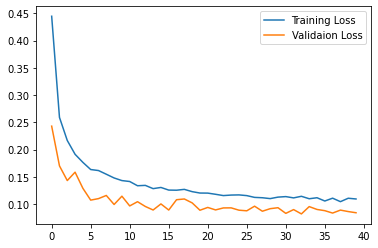

In [12]:
#Visualizing the loss history
def visualize(train_loss_history, val_loss_history):
    plt.plot(train_loss_history, label="Training Loss")
    plt.plot(val_loss_history, label="Validaion Loss")
    plt.legend()
    plt.show()
    
visualize(train_loss_history, val_loss_history)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [13]:
def testing(model):
    #Testing the trained model

    #Set the model in evaluation mode
    model.eval()

    #Initialize test loss
    test_loss = 0.0

    #Count correct predictions while testing
    test_correct = 0

    #Loop for each batch of data
    for i, data in enumerate(test_loader):
        #input images and labels
        inputs, labels = data

        #Upload data to GPU memory if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        #Output of forward pass
        outputs = model(inputs)

        #Calculate cross entropy loss
        loss = criterion(outputs, labels)

        #Extract model predictions
        _, predicts = torch.max(outputs.data, 1)

        #Calculate total number of correct predictions by comparing with labels
        num_corrects = (predicts == labels).sum().item()

        #Update the total number of correct predictions
        test_correct += num_corrects

        #Record the test loss
        test_loss += loss.item()

    #Calculate average accuracy and loss
    num_test_batches = len(test_loader)
    test_length = len(test_loader.dataset)

    avg_test_loss = test_loss/num_test_batches
    avg_test_accuracy = test_correct/test_length

    #Messages
    messages = {
        "1" : "Testing Results",
        "2" : "-"*20,
        "3" : f"\tAccuracy: {avg_test_accuracy*100:.4f}",
        "4" : f"\tLoss: {avg_test_loss:.4f}"    
    }

    #Print message
    for i in range(len(messages)):
        print(messages[f"{i+1}"])
        
testing(model)

Testing Results
--------------------
	Accuracy: 97.5900
	Loss: 0.0795


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [29]:
#To improve the model I used random learning rate and weight decay for each iteration of training

#Instantiate the model
model = Net(height, width, n_classes)

#Upload the model to GPU memory if available
model.to(device)

#Specify loss function
criterion = nn.CrossEntropyLoss()

#Specify optimizer

#Randomly pick rates
rate_list = [0.0001, 0.0005, 0.00001]
lr = np.random.choice(rate_list)
wd = np.random.choice(rate_list)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = wd)

#Creating the training and validation loop

#Number of epochs
epochs = 40

#List for loss history
train_loss_history = []
val_loss_history = []

#Training and validation loop
for epoch in range(epochs):
    
    ##Training##
    
    #Set the model in traing mode
    model.train()
    
    #Initialize training loss for each epoch
    train_loss = 0.0
    
    #Count correct predictions while training
    train_correct = 0
    
    #Loop for each batch of data
    for i, data in enumerate(train_loader):
        #input images and labels
        inputs, labels = data
        
        #Upload data to GPU memory if available
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        #Set gradient value value to zero
        optimizer.zero_grad()
        
        #Output of forward pass
        outputs = model(inputs)
        
        #Calculate cross entropy loss
        loss = criterion(outputs, labels)
        
        #Backpropagate the loss
        loss.backward()
        
        #Optimize the model by updating weights
        optimizer.step()
        
        #Set a random rate after each optimization
        lr = np.random.choice(rate_list)
        wd = np.random.choice(rate_list)
        for i in optimizer.param_groups:
            i['lr'] = lr
            i['weight_decay'] = wd
        
        #Extract model predictions
        _, predicts = torch.max(outputs.data, 1)
        
        #Calculate total number of correct predictions by comparing with labels
        num_corrects = (predicts == labels).sum().item()
        
        #Update the total number of correct predictions
        train_correct += num_corrects
        
        #Record the training loss
        train_loss += loss.item()
        
    ##Validation##
    with torch.no_grad():
    
        #Set the model in validation mode
        model.eval()

        #Initialize validation loss
        val_loss = 0.0

        #Count correct predictions
        val_correct = 0

        #Loop for each batch of data
        for i, data in enumerate(validation_loader):
            #input images and labels
            inputs, labels = data

            #Upload data to GPU memory if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            #Output of forward pass
            outputs = model(inputs)

            #Calculate cross entropy loss
            loss = criterion(outputs, labels)

            #Extract model predictions
            _, predicts = torch.max(outputs.data, 1)

            #Calculate total number of correct predictions by comparing with labels
            num_corrects = (predicts == labels).sum().item()

            #Update the total number of correct predictions
            val_correct += num_corrects

            #Record the training loss
            val_loss += loss.item()
        
    #Print accuracy and loss for each epoch
    
    #Calculating average loss and accuracy
    num_train_batches = len(train_loader)
    num_val_batches = len(validation_loader)
    train_length = len(train_loader.dataset)
    validation_length = len(validation_loader.dataset)
    
    avg_train_loss = train_loss/num_train_batches
    avg_val_loss = val_loss/num_val_batches
    avg_train_accuracy = train_correct/train_length
    avg_val_accuracy = val_correct/validation_length
    
    #Record training and validation loss history
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    
    #Messages
    messages = {
        "1" : f"Epoch: {epoch + 1}",
        "2" : "-"*10,
        "3" : "\tAccuracy:",
        "4" : f"\t\tTrain: {100*avg_train_accuracy:.4f}%",
        "5" : f"\t\tValidation: {100*avg_val_accuracy:.4f}%",
        "6" : "\tLoss:",
        "7" : f"\t\tTrain: {avg_train_loss:.4f}",
        "8" : f"\t\tValidation: {avg_val_loss:.4f}\n"    
    }
    
    #Print message
    for i in range(len(messages)):
        print(messages[f"{i+1}"])

Epoch: 1
----------
	Accuracy:
		Train: 82.4771%
		Validation: 91.3000%
	Loss:
		Train: 0.5715
		Validation: 0.2891

Epoch: 2
----------
	Accuracy:
		Train: 91.5938%
		Validation: 93.1583%
	Loss:
		Train: 0.2833
		Validation: 0.2162

Epoch: 3
----------
	Accuracy:
		Train: 93.7938%
		Validation: 95.2833%
	Loss:
		Train: 0.2108
		Validation: 0.1589

Epoch: 4
----------
	Accuracy:
		Train: 94.5708%
		Validation: 95.1667%
	Loss:
		Train: 0.1785
		Validation: 0.1610

Epoch: 5
----------
	Accuracy:
		Train: 95.1417%
		Validation: 96.4833%
	Loss:
		Train: 0.1581
		Validation: 0.1179

Epoch: 6
----------
	Accuracy:
		Train: 95.5396%
		Validation: 96.3250%
	Loss:
		Train: 0.1447
		Validation: 0.1180

Epoch: 7
----------
	Accuracy:
		Train: 96.1208%
		Validation: 96.6500%
	Loss:
		Train: 0.1308
		Validation: 0.1109

Epoch: 8
----------
	Accuracy:
		Train: 96.3854%
		Validation: 96.8333%
	Loss:
		Train: 0.1169
		Validation: 0.1019

Epoch: 9
----------
	Accuracy:
		Train: 96.5938%
		Validation: 9

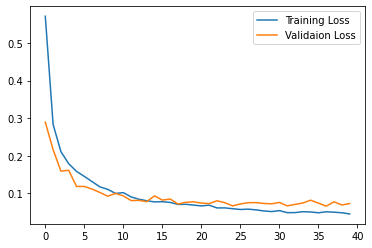

In [34]:
#Visualizing the loss history
visualize(train_loss_history, val_loss_history)

In [36]:
#Test the model
testing(model)

Testing Results
--------------------
	Accuracy: 98.1100
	Loss: 0.0618


## Saving your model
Using `torch.save`, save your model for future loading.

In [ ]:
torch.save(model, "MNIST Model v1")